<a href="https://colab.research.google.com/github/ttcielott/Deep_Learning_for_Coders_with-Fastai_and_PyTorch/blob/main/Chapter4_Under_the_hood.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning for Coders with Fastai and PyTorch
by Jeremy Howard and Sylvain Gugger

## Chapter 4. Under the Hood: Training a Digit Classifier

This notebook will write a summary of chapter 4 and run the codes for practice. The chapter explains how deep learning works under the hood.
The chapter 4 comprises of 9 parts as below.


1.   Pixels: The Foundations of Computer Vision
2.   First Try: Pixel Simialarity
3.   Computing Metrics Using Broadcasting
4.   Stochastic Gradient Descent
5.   The MNIST Loss Function
6.   Putting It All Together
7.   Adding Nonlinearity
8.   Jargon Recap
9.   Questionnaire




In [1]:
# import fastai library

from fastai.vision.all import *
import pandas as pd
import numpy as np

## 1. Pixels: The Foundations of Computer Vison

To understand what happens in a computer vision, we first have to understand how computers handle images.

Dataset for this tutorial: MNIST samples

**About MNIST dataset** 

images of handwritten digits, collected by the National Institute of Standards and Technology and collated into a machine learning dataset by Yann Lecun and his colleqgues.

In [2]:
# download a sample of MNIST
path = untar_data(URLs.MNIST_SAMPLE)

In [3]:
# view what's in this directory by using ls
# ls, a method added by fastai
# returns an object of a special fastai class called L (similar to Python List)
path.ls()

(#3) [Path('/root/.fastai/data/mnist_sample/valid'),Path('/root/.fastai/data/mnist_sample/train'),Path('/root/.fastai/data/mnist_sample/labels.csv')]

The MNIST dataset follows a common layout for machine learning dataset:

*   training set folder
*   validation set folder



In [4]:
# view what's inside the training set (folder, train)
(path/'train').ls()

(#2) [Path('/root/.fastai/data/mnist_sample/train/3'),Path('/root/.fastai/data/mnist_sample/train/7')]

There's a folder of 3s and a folder of 7s.

In [5]:
# look in folders
# sort the file to get the same order of files
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('/root/.fastai/data/mnist_sample/train/3/10.png'),Path('/root/.fastai/data/mnist_sample/train/3/10000.png'),Path('/root/.fastai/data/mnist_sample/train/3/10011.png'),Path('/root/.fastai/data/mnist_sample/train/3/10031.png'),Path('/root/.fastai/data/mnist_sample/train/3/10034.png'),Path('/root/.fastai/data/mnist_sample/train/3/10042.png'),Path('/root/.fastai/data/mnist_sample/train/3/10052.png'),Path('/root/.fastai/data/mnist_sample/train/3/1007.png'),Path('/root/.fastai/data/mnist_sample/train/3/10074.png'),Path('/root/.fastai/data/mnist_sample/train/3/10091.png')...]

In [6]:
# pick one file path
im3_path = threes[1]
im3_path

Path('/root/.fastai/data/mnist_sample/train/3/10000.png')

In [7]:
# open the file using Image class
# Image class is from the Python Image Library, PIL
# PIL is for opening, manipulation, and viewing images
im3 = Image.open(im3_path)
im3

"Convert a image to a Numpy array or a PyTorch tensor."

**Why is the conversion necessary?**

because everything is represented as a number in a computer.

In [8]:
# get a section of the image
# see how it looks like converted to a Numpy array
array(im3)[:10, :10]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,  29],
       [  0,   0,   0,   0,   0,   0,   0,  48, 166, 224],
       [  0,   0,   0,   0,   0,  93, 244, 249, 253, 187],
       [  0,   0,   0,   0,   0, 107, 253, 253, 230,  48],
       [  0,   0,   0,   0,   0,   3,  20,  20,  15,   0]], dtype=uint8)

In [9]:
# view how the image is created from the pixel values

# convert the image to a tensor
im3_t = tensor(im3)

# convert it to pandas dataframe
df = pd.DataFrame(im3_t[5:20, 5:20])
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0
1,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0
2,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0
3,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0
4,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0
5,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0
6,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0
7,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0
8,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2
9,0,0,0,0,0,0,43,98,98,208,253,253,253,253,187


In [10]:
# color-code the values using a gradient
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0
1,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0
2,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0
3,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0
4,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0
5,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0
6,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0
7,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0
8,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2
9,0,0,0,0,0,0,43,98,98,208,253,253,253,253,187


*   the number 0 : white
*   the number 255 : black
*   0 ~ 255 : grey shades


**Our goal: create a model that can recognize 3s and 7s.** How can you do it?




## 2.   First Try: Pixel Simialarity

1.   find the average pixel value for every pixel of the 3s.
2.   do the same for the 7s.
2.   see of which these two ideal digits the image is most similar to.



In [11]:
# we already have a variable of L object, a list of paths of the image 3s
threes

(#6131) [Path('/root/.fastai/data/mnist_sample/train/3/10.png'),Path('/root/.fastai/data/mnist_sample/train/3/10000.png'),Path('/root/.fastai/data/mnist_sample/train/3/10011.png'),Path('/root/.fastai/data/mnist_sample/train/3/10031.png'),Path('/root/.fastai/data/mnist_sample/train/3/10034.png'),Path('/root/.fastai/data/mnist_sample/train/3/10042.png'),Path('/root/.fastai/data/mnist_sample/train/3/10052.png'),Path('/root/.fastai/data/mnist_sample/train/3/1007.png'),Path('/root/.fastai/data/mnist_sample/train/3/10074.png'),Path('/root/.fastai/data/mnist_sample/train/3/10091.png')...]

In [12]:
# create a tensor containing all of our 3s stacked together
# using Python List Comprehension
three_tensors = [tensor(Image.open(o)) for o in threes]

Reminder : How to Convert an Image file to a Tensor

1. read the image file with Image.open.
2. convert it to a tensor.


> tensor(Image.open(image file path))



In [13]:
# do the same for 7s
seven_tensors = [tensor(Image.open(o)) for o in sevens]

In [14]:
# check the length of list
len(three_tensors), len(seven_tensors)

(6131, 6265)

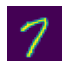

In [15]:
# display a tensor as a image using fastai's show_image function
show_image(seven_tensors[10])

In [16]:
# compute the average over all the images of the intensity of that pixel

# combine all the images in the list into a single 3-dimensional tensor (rank-3 tensor)
torch.stack(three_tensors).shape

torch.Size([6131, 28, 28])

shape attribute tells you the length of each axis.

The semantics of a tensor are up to us. As far as PyTorch is concerned, it is just a bunch of numbers in memory.

In [17]:
# rank: length of a tensor's shape
len(torch.stack(three_tensors).shape)

3

**rank** : the number of axes or dimensions in a tensor

**shape** : the size(length) of each axis of a tensor

![torch.stack](https://i.stack.imgur.com/QIHTt.png)

In [18]:
# usually when images are floats, the pixel values are expected to be between 0 and 1
# therefore, let's make them as float and divide them by 255
stacked_threes = torch.stack(three_tensors).float() / 255
stacked_sevens = torch.stack(seven_tensors).float() / 255

In [19]:
# see the cases when stacking along different dimensions (default dim = 0)
torch.stack(three_tensors, 1).shape, torch.stack(three_tensors, 2).shape

(torch.Size([28, 6131, 28]), torch.Size([28, 28, 6131]))

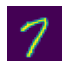

In [20]:
# display a tensor as a image
show_image(seven_tensors[10])

In [21]:
# another way to check a tensor's rank
stacked_threes.ndim

3

torch.stack function's default dim is 0. 

Regarding how it stacks tensors, please refer to the following stackoverflow page.

https://stackoverflow.com/questions/69220221/use-of-torch-stack

In [22]:
# calculate the mean of all the image tensors by taking the mean along dimension 0 of the stacked, rank-3 tensor
mean3 = stacked_threes.mean(0)
mean3.shape

torch.Size([28, 28])

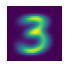

In [23]:
# according to this dataset, this is the ideal number 3
show_image(mean3)

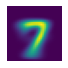

In [24]:
# do the same for 7s
mean7 = stacked_sevens.mean(0)
show_image(mean7)

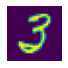

In [25]:
# let's pick an arbitrary 3 and measure its distance from our "ideal digits" (mean3 and mean7)
random3 = stacked_threes[12]
show_image(random3)

**How can we determine its distance from our ideal 3?**

We can't just add up the differences between the pixels of this images and the ideal digit because some differences will be positive, while others will be negative, and these differences will cancel out. 

**Two Main Ways**

*   Mean Absolute Difference (or L1 norm)
*   Root Mean Squared Error (or L2 norm)

In [26]:
# take the mean of  the absolute value of differences
L1_norm = (random3 - mean3).abs().mean()

# tkae the mean of the square of differences
# and then take the square root (which undoes the squaring)
L2_norm = ((random3 - mean3)**2).mean().sqrt()
L1_norm, L2_norm

(tensor(0.1286), tensor(0.2366))

In [27]:
# let's see random3's distance from the ideal 7 tensor
L1_norm_cf = (random3 - mean7).abs().mean()
L2_norm_cf = ((random3 - mean7)**2).mean().sqrt()
L1_norm_cf, L2_norm_cf

(tensor(0.1534), tensor(0.2920))

In both cases, the distance between our 3 and the ideal 3 is less than the distance to the ideal 7, so our simple model will give the right prediction in this case.

**PyTorch's loss functions**
PyTorch already provides both of these as loss functions


```
import torch.nn.functional as F # is available by default under that name in fastai
F.l1_loss(random3.float(), mean7)
F.mse_loss(random3, mean7).sqrt()
```

In [28]:
# we don't have to import Pytorch loss function
# as it is available by default under F in fastai

F.l1_loss(random3.float(), mean7), F.mse_loss(random3, mean7).sqrt()

(tensor(0.1534), tensor(0.2920))

**The Difference between L1 norm and Mean Squared Error (MSE)**

MSE will penalize bigger mistakes more heavily and be more lenient with small mistakes than L1 norm.

**NumPy Arrays VS PyTorch Tensors**

NumPy provides similar functionality and similar API to that provided by Pytorch; 

however, it does **NOT** support using the **GPU** or **calculating gradients**, which are both critical for deep learning.

<br>

| Numpy array | PyTorch tensor
|:----: | :----:  |
|       | GPU     | 
| multidimensional table |  multidimensional table |
|fast computation |  fast computation|
| jagged array  | No jagged array |
| any data type | basic numeric type |


<br>

**What is a jagged array?**
It's called 'jagged array' or 'irregular array' when member arrays have different lengths as the illustration below.

<img src="https://scaler.com/topics/images/what-is-a-jagged-array.webp" width=400></img>
 


In [29]:
# create an array or tensor
# pass a list, or a list of lists, or list of lists of lists to array or tensor
data = [[1,2,3],[4,5,6]]
arr = np.array(data)
tns = tensor(data)

arr # numpy

array([[1, 2, 3],
       [4, 5, 6]])

In [30]:
tns # pytorch

tensor([[1, 2, 3],
        [4, 5, 6]])

In [31]:
# select a row
tns[1]

tensor([4, 5, 6])

In [32]:
# select a column
tns[:, 1]

tensor([2, 5])

In [33]:
# can use the standard operations such as +, -, *, /
tns + 1

tensor([[2, 3, 4],
        [5, 6, 7]])

In [34]:
# view tensor type
tns.type()

'torch.LongTensor'

In [35]:
# automatically change the type as needed
(tns * 1.5).type()

'torch.FloatTensor'

## 3.   Computing Metrics Using Broadcasting

We're going to calculate a *metric* to tell use how good our model is. 
<br>
<br>
Loss functions such as mean absolute error or mean squared errors are not understandable to most people; in practice, we normally use *accuracy* as the metrics for classification models.
<br>
<br>
Let's calculate our metrics over a validation set.

In [36]:
# create tensors for 3s and 7s from validation set directory
valid_3_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'3').ls()])
valid_7_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'7').ls()])

# convert pixel values as float and divide by 255 to make pixel values between 0 and 1 values
valid_3_tens = valid_3_tens.float() / 255
valid_7_tens = valid_7_tens.float() / 255


In [37]:
# view the shape of tensors
valid_3_tens.shape, valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

In [38]:
# define a function that computes the distance between two images
def mnist_distance(a, b):
  return (a-b).abs().mean((-1,-2)) 
  # mean(-1, -2) tells PyTorch that we want to take the mean
  # ranging over the values indexed 
  # by the last two axes of the tensor.

**Calculate the distance to the ideal 3 for every image in the validation set**
<br>
no need to loop over 1010 images because **PyTorch will use broadcasting** when it tries to perform a simple subtraction operation between two tensors of different ranks. 

<br>

*   validation set (rank-3) :   [1010, 28, 28]
*   mean 3 (rank-2) :   [28, 28]

<br>
PyTorch will automatically expand the tensor with the smaller rank to have the same size as the one with the larger rank.


<br>
<br>
<img src = 'https://i.stack.imgur.com/kU0mv.png' width = 400></img>


PyTorch treats mean3, a rank-2 tensor representing a single image, as if it were 1,010 copies of the same image, and then subtracts each of those copies from each validation set. 

<br>

There are a couple of **important points** about how broadcasting is implemented, which makes it valuable not just for expressivity but also for performance:



*   PyTorch doesn't actually copy mean3 1,010 times. It pretends it were a tensor of that shape, but doesn't allocate any additional memory.
*   It does the whole calculation in C (or, if you'e using a GPU, in CUDA, the equivalent of C on the CPU), tens of thousands of times faster than pure Python (up to milions of times faster on a GPU).



In [39]:
# calculate the distance between validation set images of 3 and ideal image of 3
mnist_distance(valid_3_tens, mean3)

tensor([0.1225, 0.1386, 0.1156,  ..., 0.1279, 0.1117, 0.1187])

In [40]:
# create a function, is_3
def is_3(x):
  # logic: if the distance between the digit in question and the ideal 3 
  # is less than the distance to the ideal 7, then it's 3.
  return mnist_distance(x, mean3) < mnist_distance(x, mean7)

In [41]:
# let's test it. 
is_3(random3), is_3(random3).float()

(tensor(True), tensor(1.))

In [42]:
# thanks to broadcasting, we can test it on the full validation set of 3s
is_3(valid_3_tens)

tensor([ True, False,  True,  ...,  True,  True,  True])

In [43]:
is_3(valid_7_tens)

tensor([False, False, False,  ..., False, False, False])

In [44]:
# calculate the accuracy
# by taking the average of that function for all 3s and its inverse for all 7s
accuracy_3s = is_3(valid_3_tens).float().mean()
accuracy_7s = 1 - is_3(valid_7_tens).float().mean()

accuracy_3s, accuracy_7s

(tensor(0.9168), tensor(0.9854))

We're getting over 90% accuracy on both 3s and 7s.

We're classifying only 2 out of the 10 possible digits so far. To do better, let's learn about one that can automatically modify itself to improve its performance, that is, **the training process and SGD**

## 4.   Stochastic Gradient Descent

[Arthur Samuel](https://en.wikipedia.org/wiki/Arthur_Samuel_(computer_scientist) described machine learning as below.

> Suppose we arrange for some automatic means of testing the effectiveness of any current weight assignment in terms of actual performance and provide a mechanism for altering the weight assignment so as to maximize the performance. We need not to go into the details of such a performance to see that it could be made entirely automatic and to see that a machine so programmed would "learn" from its experience.

<br>

**have a model that can get better and better - that can learn.**

The problem with pixel similarity approach we practised earlier is that we can't improve it by modifying a set of parameters or weight. 

<br>

**have a weight assignments or any way of improving based on testing the effectiveness of a weight assignment**

We could look at each individual pixel and come up with a set of weights for each such that the highest weights are associated with those pixels are most likely to be black for a particular category.

> the weight for pixel where the color is white < the weight for pixel where the color is black



```
# the probability of being the number 3
def pr_three(x, w): return (x*w).sum()
```

We want to find the specific values for the vector *w* that causes the result of our fuction to be high for those images that are 3s and low for those images that are not.

**search for the best vector w** by updating the weights to make them better

<br>

**7 steps to turn this function into a machine learning classifier**

1. Initialize the weights
2. Use these weights to predict
3. Calculate its loss
4. Caculate the gradient
> Gradient measures for each weights how changing that weight would change the loss.
> The magic of calculus allows us to directly figure out in **which direction** and **by roughly how much** to change each weight.
5. Step (that is, change) all the weights based on the calculation
6. Go back to step 2 and repeat the process
7. Iterate untill you decide to stop the training process
> We would keep training until the accuracy of the model started getting worse, or we ran out of time.


**First, let's apply these steps to a simpler case than our image classification.**

In [45]:
# define a very simple function
# the quadratic
def f(x): return x**2

In [46]:
# define plot function
def plot_function(f, tx=None, ty=None, title=None, min=-2, max=2, figsize=(6,4)):
    x = torch.linspace(min,max, 100)
    fig,ax = plt.subplots(figsize=figsize)
    ax.plot(x,f(x))
    if tx is not None: ax.set_xlabel(tx)
    if ty is not None: ax.set_ylabel(ty)
    if title is not None: ax.set_title(title)

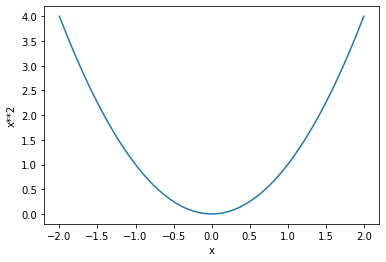

In [47]:
# display function using plot_function
plot_function(f, tx= 'x', ty ='x**2')

Let's pretend that this is our loss function, and x is a weight parameter of the function.

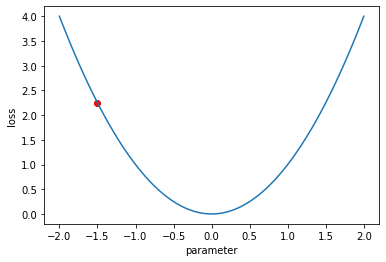

In [48]:
# pick a random value for a paramater
# calculate the value of the loss
plot_function(f, tx= 'parameter', ty= 'loss')
plt.scatter(-1.5, f(-1.5), color = 'red')
plt.show()

### Gradient Descent Process

!['gradient descent'](https://static.javatpoint.com/tutorial/machine-learning/images/gradient-descent-in-machine-learning1.png)

This basic idea goes all the way back to Isaac Newton, who pointed out that we can optimize arbitrary function in this way. 

Regardless of how complicated our functions become, this basic approach of gradient descnent will not significantly change.

### Calculating Gradients (Calculus)

* purpose: a perfomance optimization
* How much math should we understand here?
> You won't have to know how to calculate the derivatives yourself; you just have to know what a derivative is.
> Learning material: ['Khan Academy, lessons on basic derivatives'](https://www.khanacademy.org/math/ap-calculus-ab/ab-differentiation-1-new/ab-2-6a/v/derivative-properties-and-polynomial-derivatives). I made the summary of the lecture below, so if you understand the following fomular, you can skip the course.
* fomula to calculate a derivative
> $\frac{d }{dx} \left[ax^{n} \right] = anx^{n-1}$
<br><br> meaning: the derivative of $ax^{n}$ is $anx^{n-1}$
<br> e.g. $2x^{5}$ derivative is $ 2 * 5 * x^{4}$, or $10x^{4}$ and when x value is 2, the derivative at that point becomes 160.
<br><br> **What about the derivative of polynomial?** 
<br><br> $\frac{d }{dx} \left[f(x) + g(x) \right] = \frac{d }{dx} \left[f(x) \right]+ \frac{d }{dx} \left[g(x) \right] $
<br><br> meaning: the derivative of polynomial is the sum of the derivative of each terms. 
<br> e.g. $4x^3 + 5x^2 + 10x + 1$ derivative is $12x^2 + 10x + 10 and when x value is 2, the derivative at that point becomes 78. 

* other notations for a derivative:  $f'(x)$, $y'$, $\frac{dy}{dx} $ 

**Practice: Calculate the Derivative of the Function, $2x^5$**

In [49]:
# define the function
def f(x): return 2*x**5

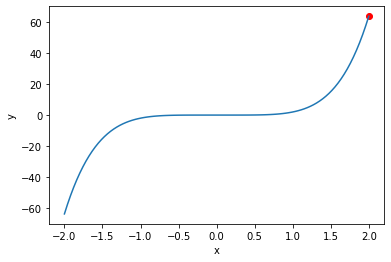

In [50]:
# display the function of x value ranges from -2 to 2. 
# mark the point that we will calculate its derivative.
plot_function(f, tx = 'x', ty = 'y')
plt.scatter(2, f(2), color = 'red')
plt.show()

In [51]:
# save the tensor of input as xt
xt = tensor(2.).requires_grad_()

In [52]:
# calculate function with the xt or 2
# and it has a gradient function it will be using to calculate when needed
yt = f(xt)
yt

tensor(64., grad_fn=<MulBackward0>)

In [53]:
# backward refers to 'backpropagation'
# backpropagation : the process of calculating the derivative of each layer
yt.backward()

In [54]:
# check the grad attribute of our tensor
xt.grad

tensor(160.)

**Practice: Calculate the derivative the Function at multiple points**

The derivative for $2x^{5}$ is $10x^{4}$.
* x = 0, the derivative is 0.
* x = 1, the derivative is 10.
* x = 1.5, the derivative is 50.625.

Let's check if the calculation matches in our output.

In [55]:
# add sum in this function
# so it can take a vector (i.e. a raank-1 tensor tensor([0., 1., 1.5]))
# and return a scalar
def f(x): return (2*x**5).sum()

In [56]:
# repeat the preceeding steps with a vector argument
xt2 = tensor([0. ,1. ,1.5]).requires_grad_()
xt2

tensor([0.0000, 1.0000, 1.5000], requires_grad=True)

In [57]:
# calculate function
yt2 = f(xt2)
yt2

tensor(17.1875, grad_fn=<SumBackward0>)

In [58]:
# backpropagation: calcuate the derivative 
yt2.backward()

# check the gradient
xt2.grad

tensor([ 0.0000, 10.0000, 50.6250])

**Practice: Calculate the derivative the polynomial function, $4x^3 + 5x^2 + 10x + 1$**

In [59]:
# define the function
def f(x): return 4*x**3 + 5*x**2 + 10*x +1

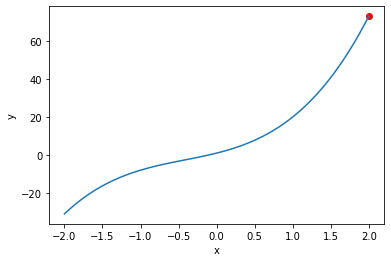

In [60]:
plot_function(f, tx = 'x', ty = 'y')
plt.scatter(2, f(2), color = 'red')
plt.show()

In [61]:
# save the x value
xt3 = tensor(2.).requires_grad_()

In [62]:
# calculate the function
yt3 = f(xt3)
yt3

tensor(73., grad_fn=<AddBackward0>)

In [63]:
# backpropagation: calculate the derivative
yt3.backward()

# check the gradient
xt3.grad

tensor(78.)

It matches the gradient we calculated manually earlier.

**So, Can We Adjust the Parameters (or Weights) only with Gradient values? No**
<br> because the gradient tell us only the slope of our function.
<br> **then what now?**
<br><br> Now, let's figure out **how far** to adjust the parameters.  
<br>
* **High Slope**  -> **More Adjustments** to do
* **Small Slope** -> **Close to the Optimal Value** 

### Stepping with a Learning Rate

How do we change our parameters (or weights) based on the values of the gradients?
<br> Answer: **Multiplying the Gradient by Some Small Number.**
<br><br> What is the small number called? 
<br> Answer: **Learning Rate (LR)**
<br><br> What is the common range of Learning Rate?
<br> Answer: **0.001 ~ 0.1** (thought it could be anything)
> Later in this book, it will guide you to a better approach (*learning rate finder*) <br> than a way of just trying a few LRs and finding which reults in the best model after training.

<br><br> You can adjust your parameter using this simple function.
<br><br> $w -= w.grad * lr $ 
<br><b>*This is known as stepping your parameters*</b> using an <b>*optimization step*</b>

<br><br>
**Gradient Descent Process by the Level of Learning Rate**
![Gradient Descent Process by the Level of Learning Rate](https://www.jeremyjordan.me/content/images/2018/02/Screen-Shot-2018-02-24-at-11.47.09-AM.png)

### And End-to-End Stochastic Gradient Descent (SGD) Example

Example: The Speed of Roller Coaster
<br><br>
<img src = 'https://live.staticflickr.com/3066/2922348063_04e40bcfa6_b.jpg' width = 250></img>
<br> We will build a model of how the speed change over time.




In [64]:
# suppose that you measured the speed of a roller coaster
# as it went over the top of a hump every second for 20 seconds

# let's create a tensor of time
time = torch.arange(0,20).float()
time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19.])

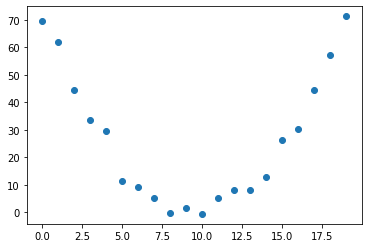

In [65]:
# the speed will be faster at the begining
# and then get slower as it went up the hill; it would be the slowest at the top
# and it would then speed up again as it went downhil

speed = torch.randn(20)*3 + 0.75*(time-9.5)**2 + 1

# speed might change by the time like this
plt.scatter(time, speed)

We've added a bit of random noise, since measuring things manually isn't precise.

Using **Stochastic Gradient Descent**, we can try to find a function that matches our observation.

Let's use a guess that it will be quadratic; i.e. a function of $a(time)^{2} + b(time) + c $.

In [66]:
# distinguish between the function's input, time and its parameters
# parameters are about which quadratic we're trying
def f(t, params):
  a,b,c = params
  return a*(t**2) + (b*t) + c

By seperating function's input and its paramters, we've restricted the problem of finding the best imaginable function that fits the data to finding the best quadratic function. 

**Step 1: Initialise the parameters**

In [67]:
# initialise the gradients
# and tell PyTorch that we want to track their gradients using requires_grad_()
params = torch.rand(3).requires_grad_()
params

tensor([0.0420, 0.9511, 0.7778], requires_grad=True)

**Step 2: Calculate the predictions**

In [68]:
# calculate the predictions
preds = f(time, params)

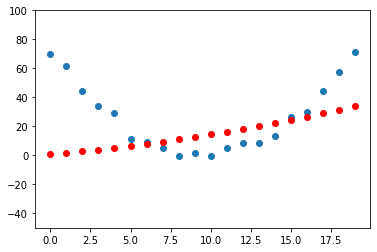

In [69]:
# create a function to show how close our predictions are to our targets
def show_preds(preds, ax = None):
  if ax is None:
    ax = plt.subplots()[1]
    
  ax.scatter(time, speed)
  ax.scatter(time, to_np(preds), color = 'red')

  ax.set_ylim(-50, 100)

show_preds(preds)

**Step 3: Calculate the loss**

In [70]:
# define a loss function
# we choose the common loss function, Mean Squared Error 
def mse(preds, targets):
  return ((preds - targets)**2).mean().sqrt()

In [71]:
# calculate the loss
loss = mse(preds, speed)
loss

tensor(27.2131, grad_fn=<SqrtBackward0>)

**Step 4: Calculate the gradients**

In [72]:
# calculate the gradients
loss.backward()

In [73]:
# view the gradients
params.grad

tensor([-34.0946,  -1.7886,  -0.4219])

**Step 5: Step the weights**

In [74]:
# pick a learing rate to use
lr = 1e-3
lr

0.001

In [75]:
params.grad, params.grad.data

(tensor([-34.0946,  -1.7886,  -0.4219]),
 tensor([-34.0946,  -1.7886,  -0.4219]))

In [76]:
# step the weights (means adjust the weights)
params.data -= lr * params.grad.data
params.grad = None

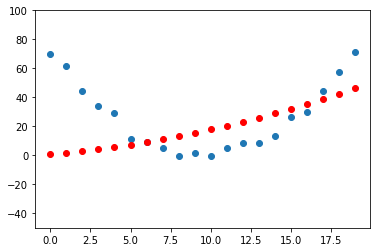

In [77]:
# see if the loss has improved
preds = f(time, params)
mse(preds, speed)
show_preds(preds)

**Step 6: Repeat the process**

In [78]:
# to repeat stepping the weights a few times
# creat a function
def apply_step(params, prn = True):
  preds = f(time, params)
  loss = mse(preds,speed)
  loss.backward()
  params.data -= lr * params.grad.data
  params.grad = None
  if prn:
    print(loss.item())
  return preds

26.646381378173828
26.645309448242188
26.645061492919922
26.644819259643555


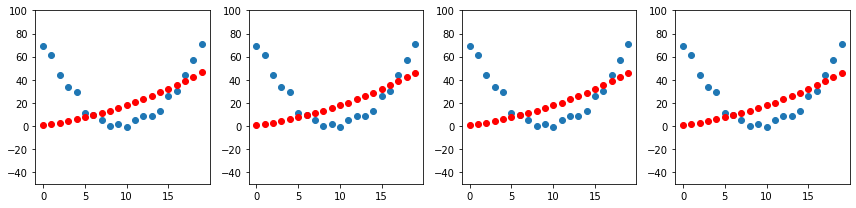

In [79]:
# repeat the process a few time
# see how the shaping is approaching the best possible function for our data
_, axs = plt.subplots(1,4, figsize=(12, 3))
for ax in axs: 
  show_preds(apply_step(params), ax = ax)
plt.tight_layout()

You can see the loss value coming down in 4 epochs.

Let's try 6 more epochs.

In [80]:
for _ in range(6):
  apply_step(params)

26.644577026367188
26.64433479309082
26.64409065246582
26.643848419189453
26.643606185913086
26.643362045288086


**Step 7: Stop** 
<br> We just decided to stop after 10 epochs arbitrarily. 
In practice, we will watch training and validation losses and our metrics to decide when to stop.

## The MNIST Loss Function

In [81]:
# concatenate dataset for training into a single tensor
# change them from a list of matrices to a list of vector
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)  # -1 means 'make this axis as big as necessary to fit all data'
train_x.shape

torch.Size([12396, 784])

In [82]:
# create labels for each image
# 1 for 3s, 0 for 7s
train_y = tensor([1]*len(threes) + [0]*len(sevens))
train_y[:10]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [83]:
train_y = train_y.unsqueeze(1)
train_y[:10]

tensor([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]])

In [84]:
# a dataset in PyTorch is required to return a tuple of (x,y) when indexed
# using zip function, create a tuple of (x, y)
dset = list(zip(train_x, train_y))
x,y = dset[0]
x.shape, y

(torch.Size([784]), tensor([1]))

In [85]:
# repeat the same process for validation dataset
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x, valid_y))

In [86]:
# create a random weight for every pixel

# create a function to create initial weights
def init_params(size, std= 1.0):
  return (torch.randn(size)*std).requires_grad_()

In [87]:
# generate weights
weights = init_params((28*28, 1)) # parentheses makes the output in a list of vector
weights[:10]

tensor([[ 1.4447],
        [-1.7266],
        [ 0.7280],
        [-0.1396],
        [ 0.0115],
        [ 1.1896],
        [ 0.3364],
        [ 1.8011],
        [-0.7006],
        [-1.2744]], grad_fn=<SliceBackward0>)

$weights*pixels$ won't be flexible enough; it is always equal to 0 when the pixels are equal to 0.

Let's make the function as $y = w*x + b$.

In [88]:
# initalise b
bias = init_params(1)
bias

tensor([-0.3903], requires_grad=True)

In neural network, the $w$ in the equation is called the *weights*, and the $b$ ius called the *bias*.

> **$w$** weight
<br> **$b$** bias

In [89]:
weights[:10].T

tensor([[ 1.4447, -1.7266,  0.7280, -0.1396,  0.0115,  1.1896,  0.3364,  1.8011,
         -0.7006, -1.2744]], grad_fn=<PermuteBackward0>)

In [90]:
train_x[7][:10]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [91]:
weights[:10].T * train_x[7][:10]

tensor([[0., -0., 0., -0., 0., 0., 0., 0., -0., -0.]], grad_fn=<MulBackward0>)

In [92]:
# calculate a prediction of one image
(weights.T * train_x[7]).sum() + bias

tensor([-1.5122], grad_fn=<AddBackward0>)

In [93]:
# using matrix multiplication, calculate the predictions of each image

# create a function for matrix multiplication
# matrix multiplication is represented with the @ operator
def linear1(xb):
  return xb@weights + bias

In [94]:
preds = linear1(train_x)
preds

tensor([[ 3.2169],
        [-1.2419],
        [-2.4528],
        ...,
        [ 2.1978],
        [ 3.7960],
        [ 2.7341]], grad_fn=<AddBackward0>)

In [95]:
# check the accuracy
corrects = (preds > 0.0).float() == train_y
corrects

tensor([[ True],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]])

In [96]:
corrects.float().mean().item()

0.5396901965141296

In [97]:
weights[0]

tensor([1.4447], grad_fn=<SelectBackward0>)

In [98]:
# let's see what the change in accuracy is for a small change in one of the weights
weights = weights.clone() 
weights[0]*=1.0001

preds = linear1(train_x)
((preds > 0.0).float() == train_y).float().mean().item()

0.5396901965141296

Now we need gradients in order to improve our model using stochastic gradient descent. For that, we need a loss function. 

**How about using Accuracy as a Loss Function?**
<br> How accuracy explained above is calculated: 
> <br> e.g. prediction is 0.8, and it's greater than 0, so the prediction becomes 1. Actual value is also 1. Accuracy is 1. When prediction is 0.3, and it's greater 0, so the prediction becomes 1. However, actual value is 0. Therefore, accuracy is 0. The final accuracy is the average value of two accuracies, which is 0.5. When we try new weights, prediction is 0.9, and it's greater than 0, so the prediction becomes 1. Actual value is also 1. Accuracy is 1. When prediction is 0.2, and it's greater 0, so the prediction becomes 1. However, actual value is 0. Therefore, accuracy is 0. The final accuracy is the average value of two accuracies, which is still 0.5. Although the predictions got closer to the actual value by using new weights, the total accuracy couldn't capture that. 


<br> There is a significant technical problem. 
> **The Gradient is 0 almost everywhere.** The model will not be able to learn from that number.<br>
<br>$gradient = \frac{(Ynew - Yold)}{(Xnew - Xold)}$
<br><br> In accuracy graph, the gradients (or slope) are mostly near zero except when prediction changes from a 3 to a 7, or vice versa.


<br>

**Let's get a slightly better loss than accuracy.**
> <br> e.g. The prediction is 0.8, and its actual value is also 1, so the loss is 0.2. For another image, when prediction is 0.3, and actual value is 0, so the loss is 0.3. The final accuracy is the average value of two losses, which is 0.25.
 When using new weights, prediction is 0.9, and its actual value is also 1, so the loss is 0.1. When prediction is 0.2, and actual value is 0, so the loss is 0.2. The final accuracy is the average value of two losses, which is 0.15. You can see the change with new weights.





In [99]:
# define the loss function for a slightly better result
def mnist_loss(predictions, targets):
  return torch.where(targets == 1, 1 - predictions, predictions).mean()
  # what it does is
  # if the target is 1, return 1 - predictions and get the mean value of them
  # otherwise, return prediction and get the mean value of them

We need **Sigmoid** function to make the prediction range between 0 and 1.

### $ sigmoid function = \frac{1 }{1 + {e^{-x}}}$

In [100]:
# we can define a sigmoid function on our own
def sigmoid(x):
  return 1/(1 + torch.exp(-x))

In [101]:
# or we can use PyTorch's accelerated version
torch.sigmoid(tensor(0))

tensor(0.5000)

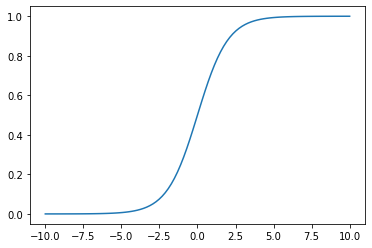

In [102]:
# plot sigmoid function to see what it looks like
plot_function(torch.sigmoid, min = -10, max = 10)

In [103]:
# add sigmoid into our mnist_loss
def mnist_loss(predictions, targets):
  preds_sig = predictions.sigmoid()
  return torch.where(targets == 1, 1 - preds_sig, preds_sig).mean()

### Recap: Why Can't We Use an Overall Accuracy for Loss?
* accuracy: to drive human understanding (accuracy has big flat sections and large jump - Not ideal for automated learning)
* loss: to drive automated learning (loss has a meaningful derivative, respond to small changes in confidence level.) 

Use Accuracy when judging the performance of a model.

### SGD and Mini-Batches

What was **Optimization Step** again? **Updating the Weights** based on the Gradients.

To take a optimization step, we need to calculate the loss over data items.
<br><br>
**Q1. Do we calculate the loss for the whole dataset?** No, it would take a long time.
<br> 
**Q2. Do we calculate the loss for a single data?** No, it is restricted to that data.
<br><br>
**Compromise!** Calculate the average loss for a few data items (this is called **Mini-Batch**) at a time. 


In [104]:
# create a mini batch of batch size 5

# create data, 0 to 14
coll = range(15)

# random shuffle the datas
# split them so as to have 5 data in each batch
dl = DataLoader(coll, batch_size =5, shuffle = True)
list(dl)

[tensor([10, 14, 13,  3,  6]),
 tensor([0, 8, 7, 2, 4]),
 tensor([12,  1, 11,  9,  5])]

**batch size**: the number of data items in the mini-batch
* Large batch size: (good) more accurate and stable estimate of the dataset's gradients from the loss function / (bad) long processing time, fewer mini-batch per epoch
* Choosing a good batch size is one of the decisions you need to make as a deep learning practitioner. 
<br>

**Selecting data at random**
We get better generalization if we can vary things during training.

**Why calculating loss with batch instead of individual data?** <br>
We nearly always do our training on an accelerator such as a **GPU**.
> These accelerator perform well only if they have lots of work to do at a time.

In [105]:
# for a training, the collection sould contain independent and dependent variables
# independent variables = inputs such as images for 3s or 7s
# dependent variables = targets such as label, 3 or 7

# let's create tuples with input and target
ds = L(enumerate(string.ascii_lowercase))
ds

(#26) [(0, 'a'),(1, 'b'),(2, 'c'),(3, 'd'),(4, 'e'),(5, 'f'),(6, 'g'),(7, 'h'),(8, 'i'),(9, 'j')...]

In [106]:
len(ds)

26

**Dataset** in PyTorch means **a collection that contains tuples of independent and dependent variables**.

In [107]:
# pass a Dataset to a Dataloader
dl = DataLoader(ds, batch_size = 6, shuffle = True)
list(dl)

[(tensor([22, 24, 13,  7,  6,  5]), ('w', 'y', 'n', 'h', 'g', 'f')),
 (tensor([20, 17, 10, 16, 25,  1]), ('u', 'r', 'k', 'q', 'z', 'b')),
 (tensor([18, 11, 19, 12, 21,  3]), ('s', 'l', 't', 'm', 'v', 'd')),
 (tensor([ 4, 23,  9,  0,  8, 14]), ('e', 'x', 'j', 'a', 'i', 'o')),
 (tensor([15,  2]), ('p', 'c'))]

The output is also tuples of tensors, and each tuple is called 'batch'.

## Putting It All Together

Previously, we defined a function, init_params as below.

```
# create a random weight for every pixel

# create a function to create initial weights
def init_params(size, std= 1.0):
  return (torch.randn(size)*std).requires_grad_()
```



In [108]:
# reinitialize our parameter
weights = init_params(28*28)
bias = init_params(1)

Previously, we created the dset as below.

```
# a dataset in PyTorch is required to return a tuple of (x,y) when indexed
# using zip function, create a tuple of (x, y)
dset = list(zip(train_x, train_y))
```



In [109]:
# create a DataLoader from a Dataset
# 256 data images will be in each batch
dl = DataLoader(dset, batch_size = 256)
xb, yb = first(dl)
xb.shape, yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [110]:
# do the same for the validation set
valid_dl = DataLoader(valid_dset, batch_size = 256)

In [111]:
# create a mini-batch of size 4 for testing
batch = train_x[:4]
batch.shape

torch.Size([4, 784])

Previously, we defined a function, linear1 as below.
```
# using matrix multiplication, calculate the predictions of each image

# create a function for matrix multiplication
# matrix multiplication is represented with the @ operator
def linear1(xb):
  return xb@weights + bias
```



In [112]:
preds = linear1(batch)
preds

tensor([  5.0141, -10.4044,  -3.0463,   9.0759], grad_fn=<AddBackward0>)

Previously, we defined a function, mnist_loss as below.


```
# add sigmoid into our mnist_loss
def mnist_loss(predictions, targets):
  preds_sig = predictions.sigmoid()
  return torch.where(targets == 1, 1 - preds_sig, preds_sig).mean()
```



In [113]:
loss = mnist_loss(preds, train_y[:4])
loss

tensor(0.4903, grad_fn=<MeanBackward0>)

In [114]:
# cacluate the gradients
loss.backward()

In [115]:
weights.grad.shape, weights.grad.mean(), bias.grad

(torch.Size([784]), tensor(-0.0018), tensor([-0.0125]))

In [116]:
# create a function putting the process above together
# a function that calculates gradients
def cal_grad(xb, yb, model):
  preds = model(xb)
  loss = mnist_loss(preds, yb)
  loss.backward()


In [117]:
# test it
cal_grad(train_x[:4], train_y[:4], linear1)
weights.grad.mean(), bias.grad

(tensor(-0.0036), tensor([-0.0250]))

In [118]:
# test it again
cal_grad(train_x[:4], train_y[:4], linear1)
weights.grad.mean(), bias.grad

(tensor(-0.0054), tensor([-0.0375]))

The gradients have changed because loss.backward adds the gradients of loss to any gradients that are current sotred. 

**So, we have to set the current gradients to 0 first.**

In [119]:
# set the current gradients to 0
weights.grad.zero_()
bias.grad.zero_()

tensor([0.])

**Method in Python whose names end in an underscore modify their objects in place.**

In [120]:
def train_epoch(model, lr, params):
  for xb, yb in dl: # each loop is of the batch that comprises of 256 images
    cal_grad(xb, yb, model)
    for p in params:
      # save the updated weights in data attribute of params(weights and bias)
      # this is to prevent the confusion
      p.data -= p.grad * lr
      # make the current gradients to zero
      p.grad.zero_()

In [121]:
# define a function that calculate the accuracy
def batch_accuracy(xb, yb):
  preds = xb.sigmoid()
  correct = (preds > 0.5) == yb
  return correct.float().mean()

In [122]:
# check if it works
batch_accuracy(linear1(train_x[:5]), train_y[:5])

tensor(0.6000)

In [123]:
def validate_epoch(model):
  accs = [batch_accuracy(model(xb), yb) for xb, yb in valid_dl]
 
  return round(torch.stack(accs).mean().item(), 4)

In [124]:
validate_epoch(linear1)

0.4446

In [125]:
# train one epoch

lr = 1.
params = weights, bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.5998

In [126]:
# do a few more
for i in range(20):
  lr = 1.
  params = weights, bias
  train_epoch(linear1, lr, params)
  print(validate_epoch(linear1))

0.8165
0.9055
0.9276
0.9404
0.9437
0.9475
0.9475
0.9499
0.9523
0.9542
0.9547
0.9562
0.9567
0.9577
0.9577
0.9581
0.9581
0.9591
0.9596
0.96


### Creating an Optimizer

Let's create an object that will handle the stochastic gradient descent step for us. 
In PyTorch, it's called an *optimizer*.


This was the linear1 function that we had created.
```
def linear1(xb):
  return xb@weights + bias
```

However, it is easier to make it using PyTorch's nn.Linear module.


In [127]:
# instead of linear1 function
linear_model = nn.Linear(28*28, 1)

It also contains both the *weights* and *bias* in a single class.

In [128]:
w, b = linear_model.parameters()
w.shape, b.shape

(torch.Size([1, 784]), torch.Size([1]))

In [129]:
class BasicOptim:
  def __init__(self, params, lr):
    self.params, self.lr = list(params), lr

  def step(self, *args, **kwargs):
    for p in self.params:
      p.data -=p.grad.data * self.lr

  def zero_grad(self, *args, **kwargs):
    for p in self.params:
      p.grad = None

In [130]:
opt = BasicOptim(linear_model.parameters(), lr)

**cal_grad function**
```
def cal_grad(xb, yb, model):
  preds = model(xb)
  loss = mnist_loss(preds, yb)
  loss.backward()
```


Previous **train_epoch** function 
```
def train_epoch(model, lr, params):
  for xb, yb in dl: # each loop is of the batch that comprises of 256 images
    cal_grad(xb, yb, model)
    for p in params:
      # save the updated weights in data attribute of params(weights and bias)
      # this is to prevent the confusion
      p.data -= p.grad * lr
      # make the current gradients to zero
      p.grad.zero_()
```



In [131]:
def train_epoch(model):
  for xb, yb in dl:
    cal_grad(xb, yb, model)
    opt.step() # each weights being updated
    opt.zero_grad() # set grad attribute to zero # updated ones are saved in data attribute


**validate_epoch function**
```
def validate_epoch(model):
  accs = [batch_accuracy(model(xb), yb) for xb, yb in valid_dl]
 
  return round(torch.stack(accs).mean().item(), 4)
```



In [132]:
# use validate function as we defined before
validate_epoch(linear_model)

0.4859

In [133]:
# put our training loop in a function
def training_model(model, epochs):
  for _ in range(epochs):
    train_epoch(model)
    print(validate_epoch(model), end = '')

In [134]:
training_model(linear_model, 20)

0.49320.89840.80760.90570.93210.94580.95410.96190.96530.96720.96920.97120.97310.97510.97550.97650.97750.9780.9780.9785

We can replace BasicOptim with fastai SGD class.

In [137]:
linear_model = nn.Linear(28*28, 1)
opt = SGD(linear_model.parameters(), lr)
training_model(linear_model, 20)

0.49320.86520.82570.90960.93360.94530.95550.96240.96530.96630.96820.97120.97360.97460.9760.97650.97750.9780.9780.9785

We can replacee training_model function with fastai's Learner.fit.

In [138]:
# to create a Learner, we first need to create a DataLoaders
# pass in training and validation
dls = DataLoaders(dl, valid_dl)

In [140]:
learn = Learner(dls, nn.Linear(28*28, 1), 
                opt_func = SGD, 
                loss_func = mnist_loss,
                metrics = batch_accuracy)

In [141]:
learn.fit(10, lr = lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.636252,0.503455,0.495584,00:00
1,0.518938,0.164847,0.870952,00:00
2,0.190308,0.190465,0.826300,00:00
3,0.083595,0.109782,0.907753,00:00
4,0.044279,0.079386,0.931796,00:00
5,0.028929,0.063321,0.947498,00:00
6,0.022599,0.053407,0.954858,00:00
7,0.019777,0.046837,0.962218,00:00
8,0.018347,0.042233,0.965162,00:00
9,0.017491,0.038847,0.967125,00:00
